# Chapter 2: Agile Tools

In this chapter we will briefly introduce our software stack, enabling you to see the tools in action and become proficient in their use.

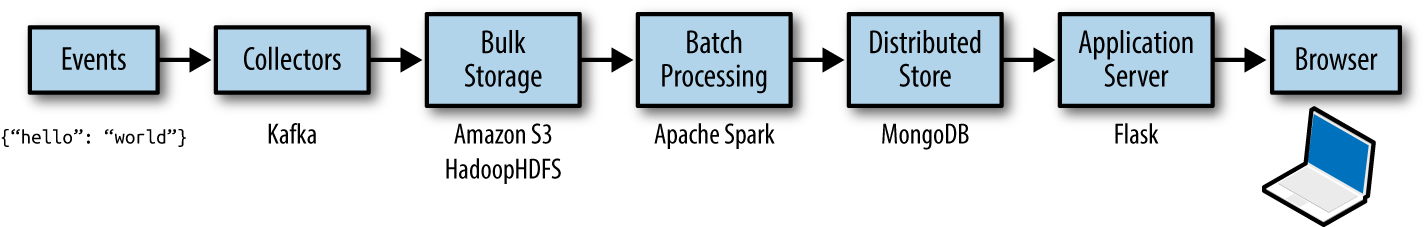

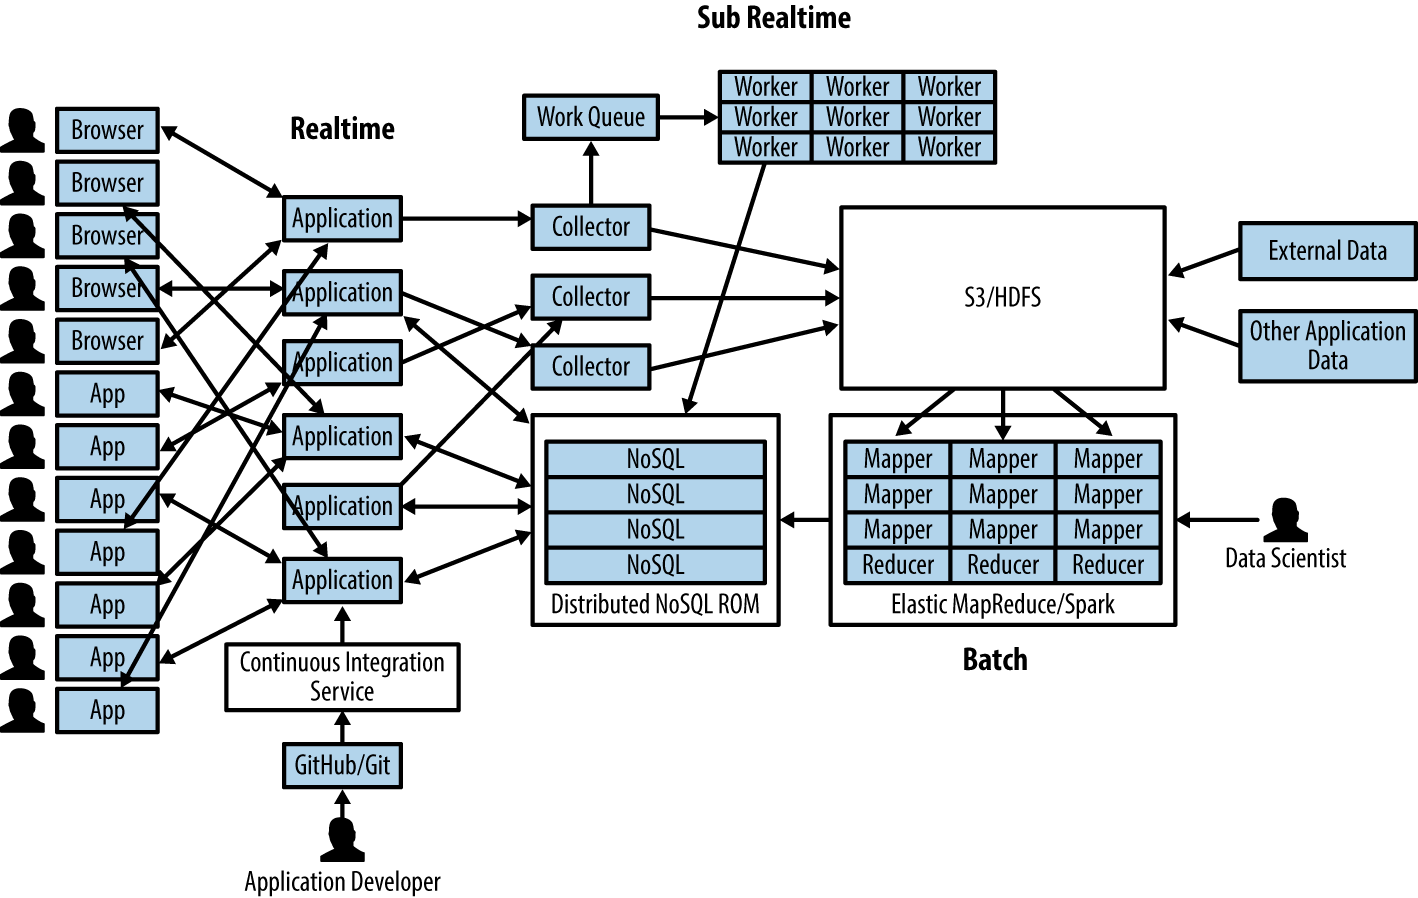

## Working with JSON

We'll be working with JSON throughout the book, both to store and process data in the 'back end' and to send data from a web application to the 'front end' web browser. In agile data science, we will often collect, process and store events in JSON format.

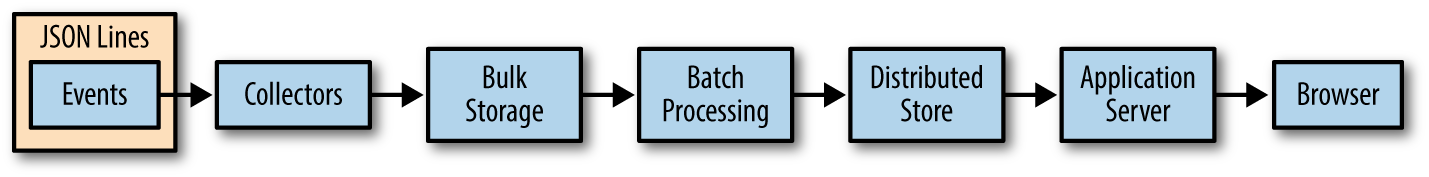



In [ ]:
#
# How to read and write JSON and JSON Lines files using Python
#
import sys, os, re
import json
import codecs

ary_of_objects = [
  {'name': 'Russell Jurney', 'title': 'CEO'},
  {'name': 'Muhammad Imran', 'title': 'VP of Marketing'},
  {'name': 'Fe Mata', 'title': 'Chief Marketing Officer'},
]

path = "/tmp/test.jsonl"

#
# Write our objects to jsonl
#
f = codecs.open(path, 'w', 'utf-8')
for row_object in ary_of_objects:
  # ensure_ascii=False is essential or errors/corruption will occur
  json_record = json.dumps(row_object, ensure_ascii=False)
  f.write(json_record + "\n")

f.close()

print("Wrote JSON Lines file /tmp/test.jsonl\n")

#
# Read this jsonl file back into objects
#
ary_of_objects = []
f = codecs.open(path, "r", "utf-8")
for line in f:
  record = json.loads(line.rstrip("\n|\r"))
  ary_of_objects.append(record)

print(ary_of_objects)

print("\nRead JSON Lines file /tmp/test.jsonl")

In [ ]:
%%bash

cat /tmp/test.jsonl

### Verifying our Work

Now lets verify that our file, `/tmp/test.jsonl` has been written. Go to the shell prompt for your virutal machine and type the command:

```
ls /tmp/test.jsonl
cat /tmp/test.jsonl
```

You should see the JSON that we wrote reproduced in your console.

## Data Processing with Spark

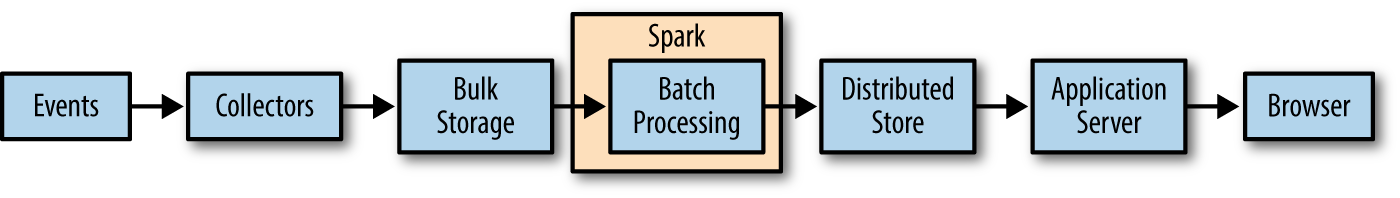

Once we have our data files on disk, we will use Spark to process them. Spark is a general purpose computing framework that scales well to handle large datasets by being distributed across multiple PC machines. In fact, Spark is the leading general-purpose distributed data processing platform. 

Spark works by breaking up data processing across networks of commodity PC machines, each acting on data on its own local disk and RAM. Spark’s job is to coordinate these machines into a single computing platform. The fact that Spark is a distributed platform is essential to it scaling to data of any size, and Spark is great at this. It works well in “local mode” on one machine, and it works well on clusters of thousands of machines. This meets our requirement that our tools scale to data of any size. Spark is also excellent glue, with connectors to many different systems including Kafka and databases like MongoDB.

Spark for Python is called PySpark. We'll be using PySpark, but note that Spark can also work with other languages like Java, Scala or R.

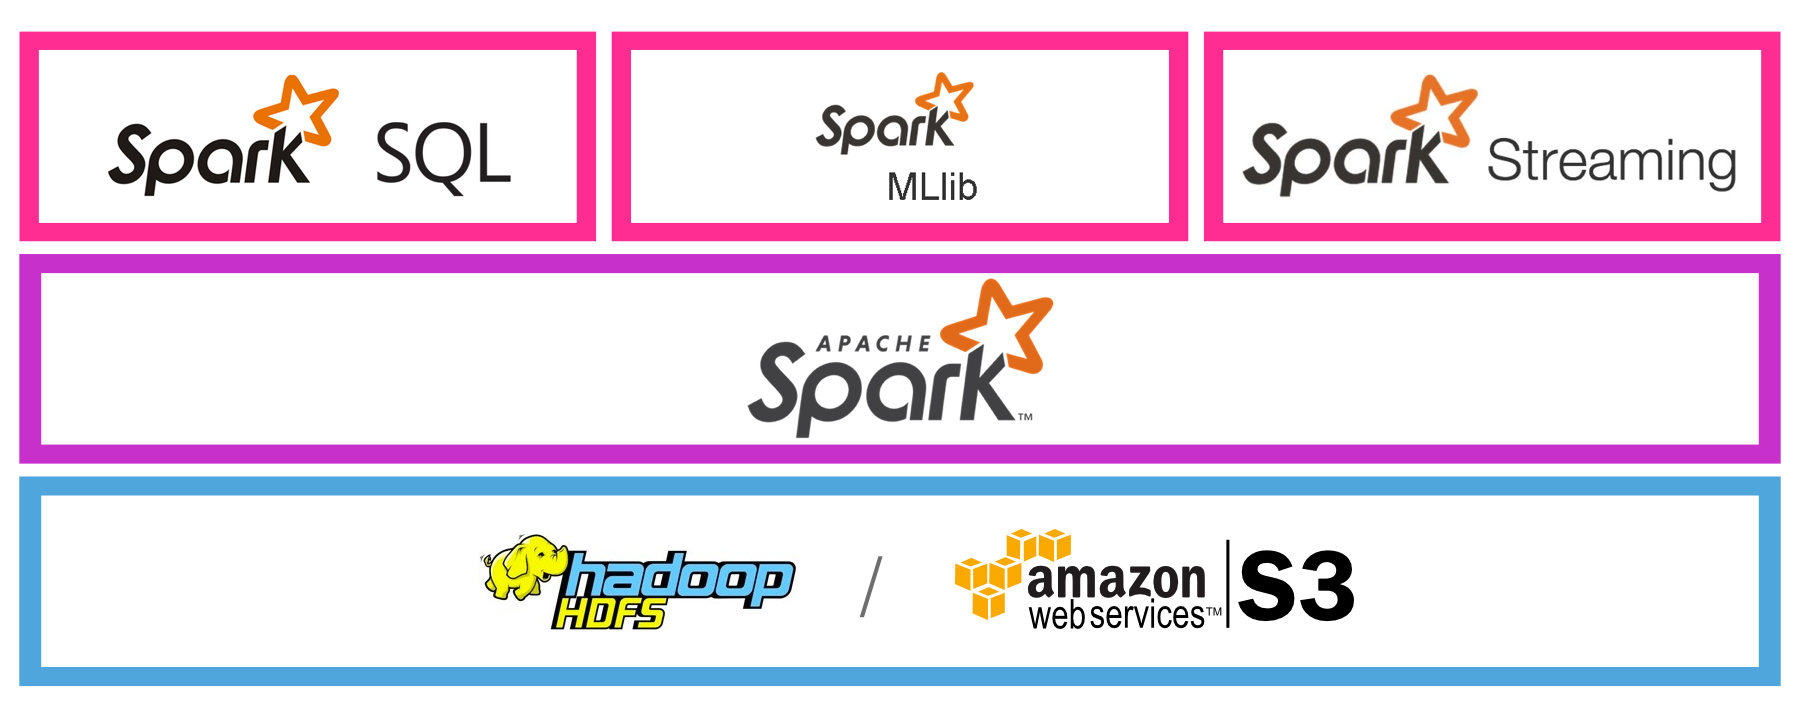

The image above describes the Spark ecosystem. Spark runs on top of HDFS or S3 and includes Spark SQL, Spark MLlib, and Spark Streaming. We'll be using Spark SQL and Spark MLlib later in this tutorial.

Spark __local mode__ lets us run Spark on small data locally, for development. We’ll be using Spark local mode throughout this course. The idea is that you can develop locally to learn, and then later on use a Spark cluster as your data grows —- although we should note that, with EC2 instances available with 2 TB of RAM, “local mode” in Spark can still process pretty big datasets! The reason to use a cluster, then, is more around reliability through redundancy and satisfying the cost/benefit curve, where multiple cheaper machines are less expensive than one monster.

## Initializing PySpark

We will be working with PySpark directly from Jupyter notebooks like this one. In order to initialize PySpark, you will need to run the following code. Give your application a name like `"Introducing PySpark"` and then run the code below. 

This will initialize the two objects you will need to use Spark: `SparkContext`, which is named `sc` and `SparkSessions` which is named `spark`. We will see how to use these two objects to perform work below.

In [ ]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

You should see the words `PySpark initialized...` appear just above this text. This means you are ready to process data in Spark!

### Our First Spark Job

For our first Spark job, we're going to load some CSV (Comma Separated Value) data and count the number of records present. Note the use of the `map` command to run a function on each record (a line of text as input, and a list as output), and the use of the `collect` method to gather data from PySpark's memory (potentially on a large compute cluster) to local memory (on this machine you're using).

In [ ]:
%%bash

cat ../data/example.csv

In [ ]:
csv_lines = sc.textFile("../data/example.csv")
data = csv_lines.map(lambda line: line.split(","))
data.first()

In [ ]:
a = lambda x: x * 2

print(a(2))

def b(x):
    return x * 2

print(b(2))

In [ ]:
data.collect()

In [ ]:
data.take(2)

You can count the number of records in any RDD with the `count` method.

In [ ]:
data.count()

## Dicts are Easier to Work With than Lists

It is easier to work with records that have named fields than to work with lists with numeric fields. Before we proceed, lets convert our data into dictionaries.

In [ ]:
dict_data = data.map(
    lambda record: { 'name': record[0], 'company': record[1], 'title': record[2] }
)
dict_data.collect()

### Printing Data as JSON

Sometimes it is hard to read records without proper formatting. The `json` module can help with its `sort_keys` and `indent` options.

In [ ]:
import json
print(
    json.dumps(
        dict_data.collect(),
        indent=4,
        sort_keys=True
    )
)

### Grouping Data

The `GROUP BY` is a fundamental operation in data processing. Lets see how this works in Spark. We will group the list of executives by job title.

In [ ]:
grouped_by_title = dict_data.groupBy(
    lambda record: record['title']
)
grouped_by_title.collect()

### Inspecting Grouped Data

Note that `RDD.groupBy` produces a tuple with two fields: the key we grouped by and a `pyspark.resultiterable.ResultIterable.` If you want to inspect each group, you can cast the `ResultIterable` to a `list`.

In [ ]:
record_groups = grouped_by_title.map(
    lambda record: (
        record[0], 
        list(record[1])
    )
)

record_groups.collect()

Once again, we can use JSON to more clearly format the data. This shows our grouped records: the group key, followed by a `list` of `dict` objects with the fields of our original `dict` records. There is nothing special about grouped data, it is simply grouped to be processed in its group context.

In [ ]:
print(json.dumps(record_groups.collect(), indent=4, sort_keys=True))

## Counting Grouped Data

In the `pyspark.RDD` API, the way we count groups is to use raw Python, the `len` command. We'll see later how the `pyspark.SQL` API uses higher level functions to do the same calculation.

In [ ]:
title_counts = grouped_by_title.map(
    lambda record: (
        record[0], 
        len(record[1])
    )
)
title_counts.collect()

### PySpark Summary

We'll come back to PySpark, but first lets introduce MongoDB!

## Introducing MongoDB

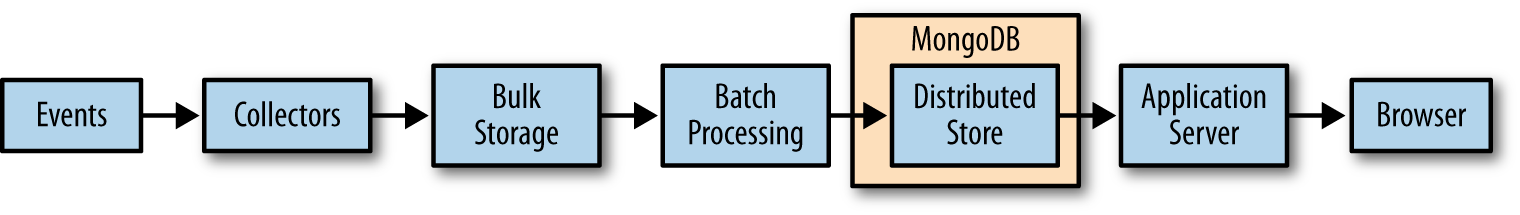

Once we have processed data, we need to __publish__ it somewhere so it can be accessed and used. We use MongoDB to accomplish this. 

### Opening a Terminal

To access MongoDB, we will use a terminal. Open the Home tab of your browser, or click [here](/). 

Now select the `New` menu item at the top right, and then select `Terminal`. 

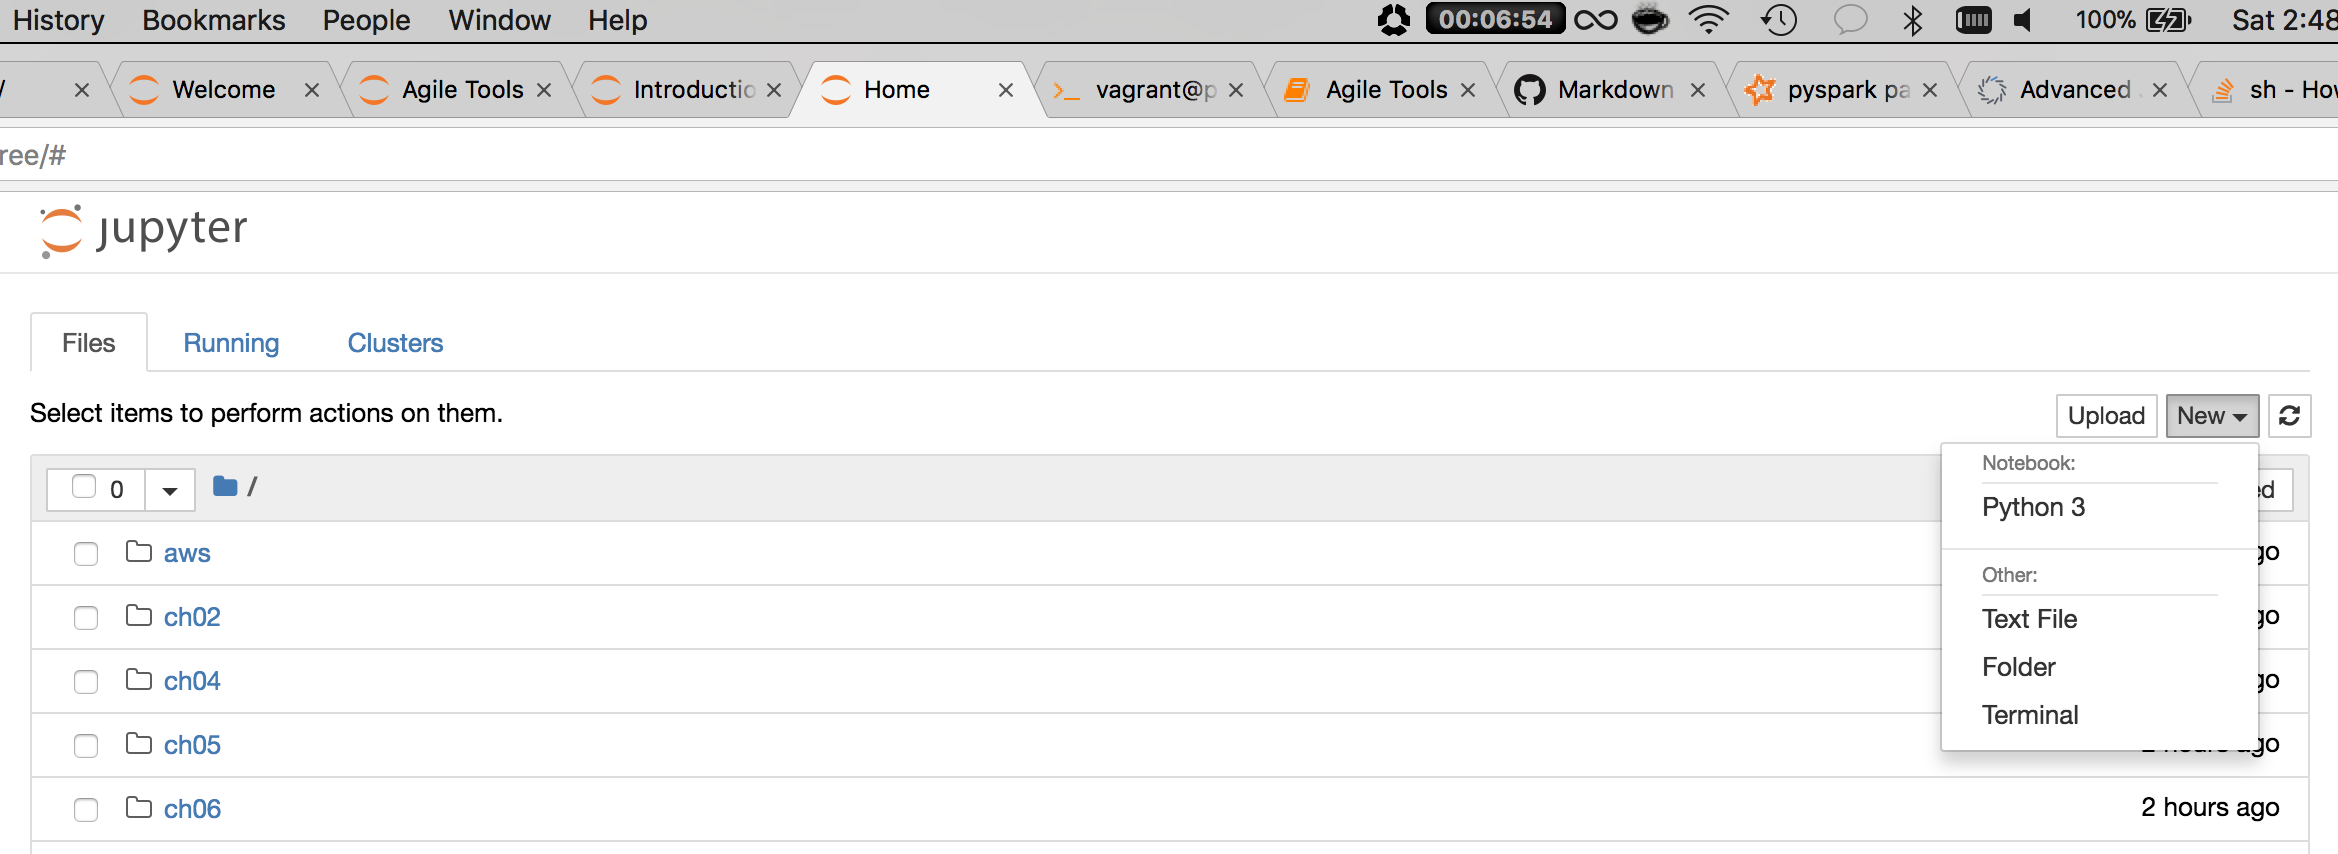

This will open up a new shell terminal in a new tab.

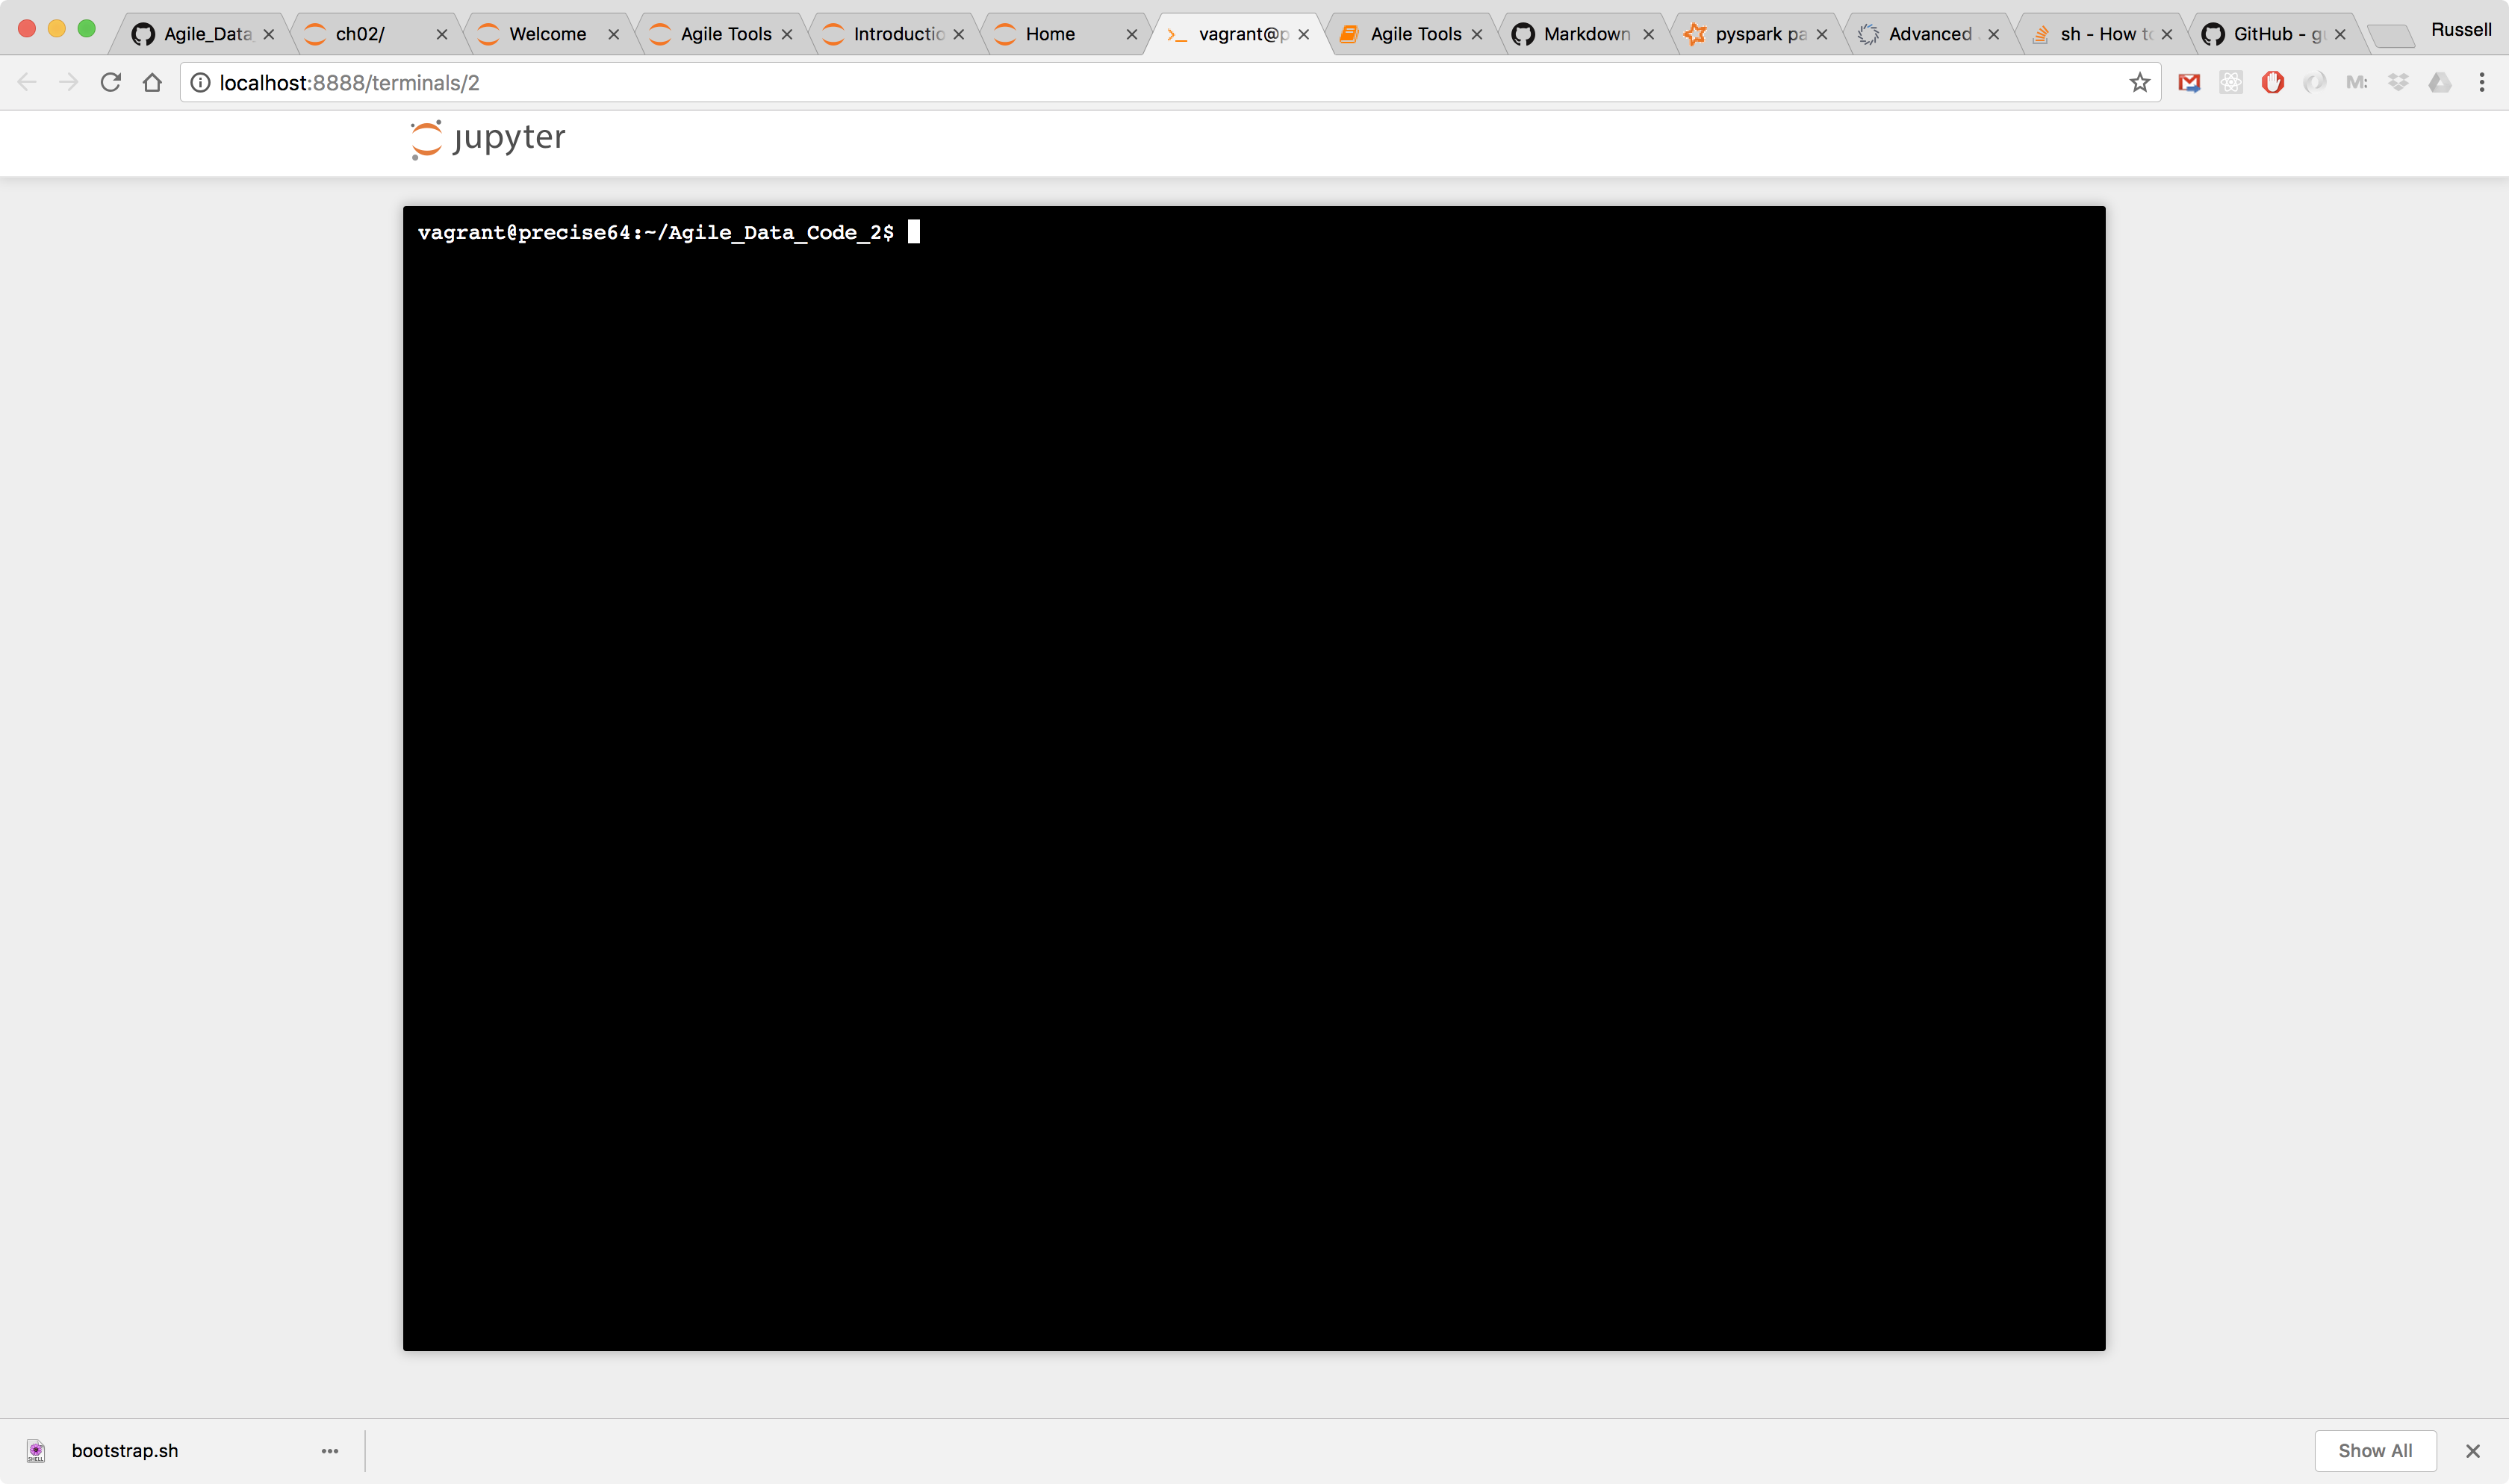

At the terminal prompt, now bring up the mongo shell by typing: 

```
mongo agile_data_science
```

This will bring up a prompt with a `>` next to it. This is where you enter commands to be executed by MongoDB.

Begin by listing the collections in the database. 

```
show collections
```

This will list nothing in particular, only system collections because we haven't created any yet. Lets create one now. In MongoDB you can create a collection by inserting a single record. Lets insert a record describing me, Russell Jurney!

```
db.my_collection.insert({"name": "Russell Jurney"});
```

`db` is shorthand for database. It references the database we have open, in this case `agile_data_science`. Next comes `my_collection` which refernces the collection or table inside the database we want to access. Next comes a collection command. In this case we `insert` a record, which we enter as JSON.

Now that the record is inserted and the table exists, we can find the record.

```
db.my_collection.find({"name": "Russell Jurney"});
```

And it will return the record you entered! As you can see, using MongoDB is simple. That is why it is part of our stack.

## Publishing Data to MongoDB from PySpark

Pushing data to MongoDB from PySpark is easy with the `pyspark_mongodb` package.

Note that we have already configured PySpark to connect to MongoDB via the mongo-hadoop project, so we can run PySpark as normal. Now we will use the `pymongo_spark` module to store the documents to MongoDB that we loaded earlier. Note that we must both import and activate the `pymongo_spark` package in order for it to add the `saveToMongoDB` method to the `pyspark.RDD` interface:

In [ ]:
import pymongo_spark
# Important: activate pymongo_spark
pymongo_spark.activate()

csv_lines = sc.textFile("../data/example.csv")
data = csv_lines.map(lambda line: line.split(","))
schema_data = data.map(
  lambda record: {'name': record[0], 'company': record[1], 'title': record[2]}
)
schema_data.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.executives'
)

print("Data sent to Mongo!")

### Verifying Data in MongoDB

Now jump back to your terminal tab and run the following command:

```
db.executives.find()
```

You should see that the records we loaded and computed are now in MongoDB. It only takes one line of code to send data to MongoDB. Nice, right?

## Searching Data with Elasticsearch

If we want to search data, we use Elasticsearch, which provides a robust, easy-to-use search solution that lowers the barrier of entry to individuals wanting to search their data, large or small. Elasticsearch has a simple RESTful JSON interface, so we can use it from the command line or from any language. We’ll be using Elasticsearch to search our data, to make it easy to find the records we’ll be working so hard to create.

### Creating an Elasticsearch Index
To create an elasticsearch index for all our documents, we will run the following command in a terminal using the `%%bash` command and `curl` to send elasticsarch JSON data describing our index.

In [ ]:
%%bash

curl -XPUT 'localhost:9200/agile_data_science?pretty' \
  -H 'Content-Type: application/json' -d'
{
    "settings" : {
        "index" : {
            "number_of_shards" : 1, 
            "number_of_replicas" : 1 
        }
    }
}
'

You should see the following response:

```
{
  "acknowledged" : true,
  "shards_acknowledged" : true
}
```

### Storing to Elasticsearch with `curl`

Now lets try inserting a record, and then reading it back. To insert a record, run:

In [ ]:
%%bash
curl -XPUT 'localhost:9200/agile_data_science/test/1?pretty' \
  -H 'Content-Type: application/json' -d'
{
    "name" : "Russell Jurney",
    "message" : "trying out Elasticsearch"
}
'

### Searching Elasticsearch with `curl`
To read the record back, run:

In [ ]:
%%bash

curl -XGET 'localhost:9200/agile_data_science/_search?q=name:Russell&pretty'

## Elasticsearch and PySpark

To write data from PySpark to Elasticsearch (or read data from Elasticsearch to PySpark), we’ll need to use a project called Elasticsearch for Hadoop, which includes Spark support. We have already preconfigured PySpark to use this project, so you won’t need to do anything special to load this library.

### Storing Data in Elasticsearch

To store data in elasticsearch, we simply call the `RDD.saveAsNewAPIHadoopFile` API configured to use the Elasticsearch for Hadoop library.

In [ ]:
csv_lines = sc.textFile("../data/example.csv")
data = csv_lines.map(lambda line: line.split(","))
schema_data = data.map(
  lambda x: ('ignored_key', {'name': x[0], 'company': x[1], 'title': x[2]})
)
schema_data.saveAsNewAPIHadoopFile(
  path='-', 
  outputFormatClass="org.elasticsearch.hadoop.mr.EsOutputFormat",
  keyClass="org.apache.hadoop.io.NullWritable", 
  valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
  conf={ "es.resource" : "agile_data_science/executives" })

print("Saved data to Elasticsearch!")

### Querying Elasticsearch

We can again use `curl` to query Elasticsearch to verify whether our data stored successfully or not.

In [ ]:
%%bash

curl 'localhost:9200/agile_data_science/executives/_search?q=name:Russell*&pretty'

### Inspecing our Records

Note the records now look like this (for example):

```json
      {
        "_index" : "agile_data_science",
        "_type" : "executives",
        "_id" : "AWL1bEp0GvFw0fJ74-O4",
        "_score" : 1.0,
        "_source" : {
          "company" : "Relato",
          "name" : "Russell Jurney",
          "title" : "CEO"
        }
      },
```

Elasticsearch has generated an _id for us and has added other metadata to each record returned, including a score on how well the record matched the query.

This is a good time to point out that Elasticsearch is a great key/value or document store! It could easily replace MongoDB in our stack, and doing so could simplify and enhance scalability by reducing components. Remember, simplicity is key to scalability. That being said, Mongo has features we’ll be thankful for later, so don’t write it off.

## Python and Elasticsearch

In our web applications we will need to access Elasticsearch from within Python but outside Spark. To do so we use the `pyelasticsearch` Python library.

Using `pyelasticsearch` is easy. Running the code below, you should see much the same content as was returned from Elasticsearch via `curl`.

In [ ]:
from pyelasticsearch import ElasticSearch
es = ElasticSearch('http://localhost:9200/')
print(es.search('name:Russell', index='agile_data_science'))

print('HELLO')


## Distributed Streams with Apache Kafka

According to its website, “Kafka™ is used for building real-time data pipelines and streaming apps. It is horizontally scalable, fault-tolerant, wicked fast, and runs in production in thousands of companies.” We’ll be using Kafka streams to make predictions in “sub real time,” using Spark Streaming. Kafka can also be used to collect data and aggregate it to bulk storage like HDFS or Amazon S3.

Kafka is already running on the virtual image given to you for this course.

### Listing Kafka Topics

Kafka organizes data by topic. Lets use the `kafka-topics.sh` utility that is included with Kafka to list the topics. We'll have to give the command the local address to our Zookeeper service, at port 2181.

In [ ]:
%%bash 

/home/ubuntu/kafka/bin/kafka-topics.sh --zookeeper localhost:2181 \
--create --topic test --partitions 1 --replication-factor 1

In [ ]:
%%bash

/home/ubuntu/kafka/bin/kafka-topics.sh  --zookeeper localhost:2181 --list

### Testing Kafka with the Console Consumer and Producer

The `test` topic is there for testing. Lets use another two utilities to test our Kafka cluster out using the test topic: the console producer and consumer. The console producer accepts text from the console and produces a new Kafka message each time you press enter. The console consumer monitors a topic and prints any messages to standard output. 

#### Using the Console Producer

In combination, these two tools can be used to test a Kafka topic. First you run both tools in two consoles, then you type text in the console producer and watch it show up in the console consumer. We will modify this procedure to work in a notebook. We will use the `timeout` command to run the console producer for ten seconds, and feed it three messages from standard input.

In [ ]:
%%bash

# First lets create a message file with three messages
echo "message 1, getting going..." > /tmp/messages.txt
echo "message 2, in business!" >> /tmp/messages.txt
echo "message 3, all done, woohoo!" >> /tmp/messages.txt

# Then we'll send the file through the console producer
timeout 10 \
    /home/ubuntu/kafka/bin/kafka-console-producer.sh \
        --topic test \
        --broker-list localhost:9092 \
            < /tmp/messages.txt

#### Using the Console Consumer

Next we'll use the `timeout` command to run the console consumer for five seconds, with the `--from-beginning` option so it will print the messages we just sent from the console producer a moment ago. Note that we also need to give the `--bootstrap-server` and `--topic` arguments to specify the Kafka server address and topic.

In [ ]:
%%bash

timeout 5 \
    /home/ubuntu/kafka/bin/kafka-console-consumer.sh \
        --topic test \
        --bootstrap-server localhost:9092 \
        --from-beginning &2>/dev/null

## Realtime Versus Batch Computing

Using Kafka is straightforward, but we’ll see later how this simple framework can create complex dataflows in a way that is simple to operate. The global queue abstraction Kafka provides is extremely powerful. We’ll only be using Kafka to deploy predictions using Spark Streaming, but it can do much more.

Despite Kafka’s power, we’ll spend most of our time in this book doing batch processing. The rule is, “If you can do it in batch, you should do it in batch.” Operating a Spark cluster is much simpler than operating a pool of realtime workers using Kafka. While you can replay Kafka’s history to do the equivalent of batch operations, batch computing is optimized for the process of applied research that constitutes data science work.

If you do decide to move from batch computing to realtime streams, though, PySpark has you covered! You can use the same code with PySpark Streaming to process messages in Kafka that you used to process them in batch mode using PySpark. It is quite natural to prototype streaming applications in batch and then convert them to streams later.

## Kafka with Python via `kafka-python`

Kafka can be accessed through libraries in all popular languages. The `kafka-python` library is the easiest Python library to work with, and we'll be using it to deploy machine learning models in realtime.

### Producing Kafka Messages

#### Setting up a `KafkaProducer`

First we import the `KafkaProducer` class from the `kafka` module. Then we instantiate a `KafkaProducer`, feeding it arguments for the bootstrap server list and the API version we'll be using during this Kafka session.

In [ ]:
from kafka import KafkaProducer
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    api_version=(0,10)
)
print("Producer instantiated!")

#### Producing Messages

Next we will use our producer to produce (transmit) ten JSON messages. Note that we have to encode our data in a character format because Kafka uses bytes, not strings. The default encoding is `utf-8`. First we instantiate a `KafkaConsumer`, create a message `dict`, serialize it as JSON, encode the JSON string as `bytes` and transmit it via the producer's `send` method, specifying the topic.

In [ ]:
names = ["Alan", "Bob", "Carol", "Delia", "Edward", "Fu", "Greg", "Howard", "Irene", "Justin"]
for i in range(0,10):

    # Create a fun message
    name = names[i]
    message = {
        "i": i,
        "message": "Hello, {}!".format(name)
    }
    
    # Serialize in JSON and encode our message into bytes
    message_json = json.dumps(message, ensure_ascii=False)
    message_bytes = message_json.encode() # defaults to utf-8
    print(message_bytes)
    
    # Transmit the bytes to the test topic
    producer.send("test", message_bytes)
    print("Sent message {}".format(i))

### Consuming Kafka Messages


#### Setting up a `KafkaConsumer`

We first import the `KafkaConsumer` and `TopicPartition` classes from the `kafka` package. Next we instantiate a `KafkaConsumer`, specifying its `TopicPartition` to use topic test, partition zero. Then we seek to the beginning of the topic - something we must do because concurrent operations aren't possible in a notebook so we have to do one then the other, which requires us to seek to the beginning to see the messages already sent.

In [ ]:
import sys, os, re
import json

from kafka import KafkaConsumer, TopicPartition
consumer = KafkaConsumer()
consumer.assign([TopicPartition('test', 0)])
consumer.seek_to_beginning()

print("KafkaConsumer instantiated!")

#### Receiving Kafka Messages

To read Kafka messages we simply loop on the `KafkaConsumer` object, decode the messages' bytes as strings, and print each message. 

We stop when we hit thirteen messages - the number we've sent overall so far. Again, this stopping is something we do for demonstration purposes - in reality you would run your consuming worker continuously so long as it is needed.

In [ ]:
for i, message in enumerate(consumer):
    message_bytes = message.value
    message_string = message_bytes.decode() # utf-8 default
    
    print(message_string)
    
    # Stop after thirteen records, 0-12
    if i >= 12:
        break

## Lightweight Web Applications

The next step is turning our published data into an interactive application. As shown in Figure 2-18, we’ll use lightweight web frameworks to do that.

We choose lightweight web frameworks because they are simple and fast to work with. Unlike with CRUD applications, mined data is the star of the show here. We use read-only databases and simple application frameworks because that fits with the applications we build and how we offer value.

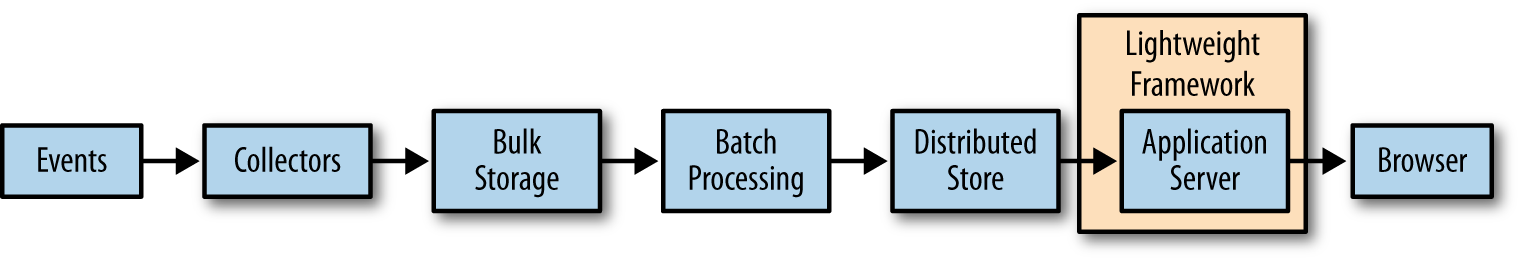

Given the following examples in Python/Flask, you can easily implement a solution in Sinatra, Rails, Django, Node.js, or your favorite language and web framework.

### Web Applications in Jupyter Notebooks

It is not possible to run a web server, a continuous process, inside a Jupyter Notebook. Therefore in this section we will display the code in the notebook but direct you to a terminal to run and interact with the web applications directly.

If you haven't already, look above for directions on opening a terminal and do so now. Otherwise move to a terminal and change directories to `ch02`, subdirectory `web`.

### Echo Microservice in Flask

The first web application we will build will be a Flask microservice that returns whatever text you give it as part of the url. The code for this service is simple:

```python
from flask import Flask
app = Flask(__name__)

@app.route("/<input>")
def hello(input): 
  return input

if __name__ == "__main__": app.run(debug=True)
```

To run this web application, in your terminal in the `ch02/web` directory, execute the `test_flask.py` file with Python.

```bash
cd ch02/web
python ./test_flask.py
```

Now in a new tab of your browser, open up the following url: [http://localhost:5000/echo test](http://localhost:5000/echo%20test) You will see that it echoes back any text that you put after the final / in the url. 

Lets use `curl` to verify things are working:

In [ ]:
%%bash

curl http://localhost:5000/hello%20world!

Normally you would use the CTRL-C character to stop the Flask server process, but this does not work in a Jupyter Terminal, so to shut down this web process, visit [http://localhost:5000/shutdown](http://localhost:5000/shutdown) This is how we will shut down all of our web applications.

### `pymongo` and Flask

Lets use the `pymongo` module we used earlier to return some data as JSON in response to a web request. The code to do so looks like:

```python
from flask import Flask
from pymongo import MongoClient
import bson.json_util

# Set up Flask
app = Flask(__name__)

# Set up Mongo
client = MongoClient() # defaults to localhost
db = client.agile_data_science

# Fetch executives by name
@app.route("/executive/<name>")
def executive(name):
  executive = db.executives.find({"name": name})
  return bson.json_util.dumps(list(executive))

if __name__ == "__main__": app.run(debug=True)
```

First we import `flask.Flask`, `pymongo.MongoClient` and `bson.json_util`. We setup an application object which we'll use to setup routes and to run the Flask test web server. Next we instantiate our `MongoClient`, and setup the database handle.

Then we setup a route to the url `/executive/<name>` where `name` is an argument. 

In the same directory in your terminal, `ch02/web`, run the `test_flask_mongo.py` script.

```bash
python ./test_flask_mongo.py
```

Now visit [http://localhost:5000/executive/Russell Jurney](http://localhost:5000/executive/Russell%20Jurney) and see Flask use Mongo to retrieve a record about your teacher :) You should see the following JSON, which we stored before:

<img src="./images/json.png" alt="Two JSON Records of Executive Russell Jurney" style="width: 40%;"/>

Making Mongo work with Flask is as easy as that! Note how MongoDB has added an ID to each record. Now let's make it presentable.

## Bootstrap

Design and presentation impact the value of your work. In fact, one way to think of Agile Data Science is as iterative data design. The output of our data models matches our views, and in that sense design and data processing are not distinct. Instead, they are part of the same collaborative activity: data design. With that in mind, it is best that we start out with a solid, clean design for our data and work from there.

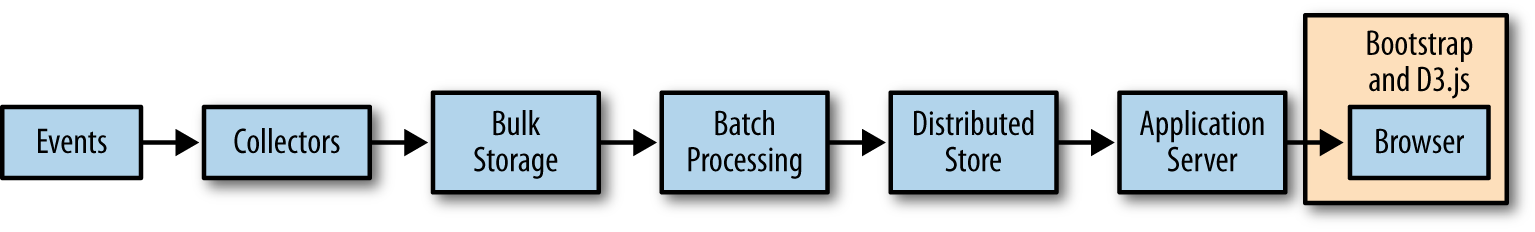

Let's try wrapping our previous example in an HTML table, styled with Bootstrap.

```python
from flask import Flask, render_template
from pymongo import MongoClient
import bson.json_util

# Set up Flask
app = Flask(__name__)

# Set up Mongo
client = MongoClient() # defaults to localhost
db = client.agile_data_science

# Fetch from/to totals, given a pair of email addresses
@app.route("/executive/<name>")
def executive(name):
  executives = db.executives.find({"name": name})
  return render_template('table.html', executives=list(executives))

if __name__ == "__main__":
  app.run(
    debug=True,
    host='0.0.0.0'
  )
```

Next we need to create the HTML template `table.html` to wrap our data in a presentable form. We first create a title for our page, then a table with a header row and successive data rows.

```html
<div class="container">
  <div class="page-header">
    <h1>Agile Data Science</h1>
  </div>
  <p class="lead">Executives</p>
  <table class="table">
    <thead>
      <th>Name</th>
      <th>Company</th>
      <th>Title</th>
    </thead>
    <tbody>
      {% for executive in executives -%}
      <tr>
        <td>{{executive.name}}</td>
        <td>{{executive.company}}</td>
        <td>{{executive.title}}</td>
      </tr>
      {% endfor -%}
    </tbody>
  </table>
</div>
```

Now go to your Terminal and now run the file [`ch02/web/test_flask_bootstrap.py`](web/test_flask_bootstrap.py) from the `ch02/web` directory:

```bash
cd /home/vagrant/Agile_Data_Code_2
cd ch02/web
python ./test_flask_bootstrap.py
```

And now visit the same url: [http://localhost:5000/executive/Russell Jurney](http://localhost:5000/executive/Russell%20Jurney)

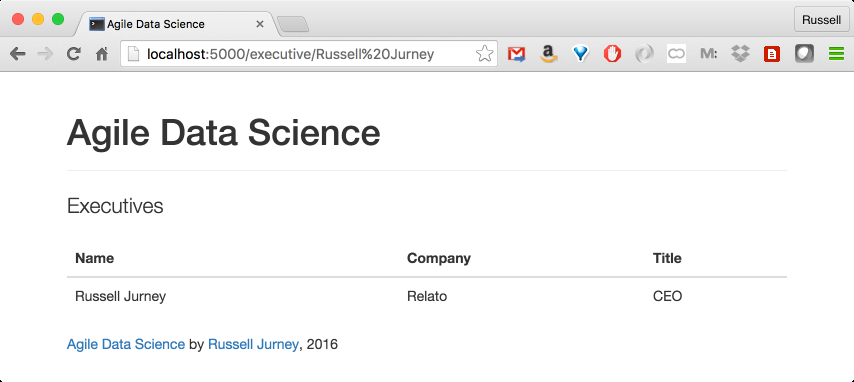

Congratulatations, you've created a data-backed web page!

## Conclusion

We’ve toured our environment and have executed “Hello, World!” in each tool. Together, these tools form a data pipeline of distributed systems capable of collecting, processing, publishing, and decorating data of any size. This pipeline is easy to modify at every stage with one line of code. This pipeline will scale without our worrying about optimization at each step—optimization will be one concern, but not our main concern.

As we’ll see in the next chapter, because we’ve created an arbitrarily scalable pipeline where every stage is easily modifiable, it is possible to return to agility. We won’t quickly hit a wall as soon as we need to switch from a relational database to something else that “scales better,” and we aren’t subjecting ourselves to the limitations imposed by tools designed for other tasks, like online transaction processing.

We now have total freedom to use best-of-breed tools within this framework to solve hard problems and produce value. We can choose any language, any framework, and any library and glue it together to get things built.